<a href="https://colab.research.google.com/github/SamreenNaz/ChronicKidney_Prediction_Models.git./blob/main/ROC_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded successfully!
Training SVM...


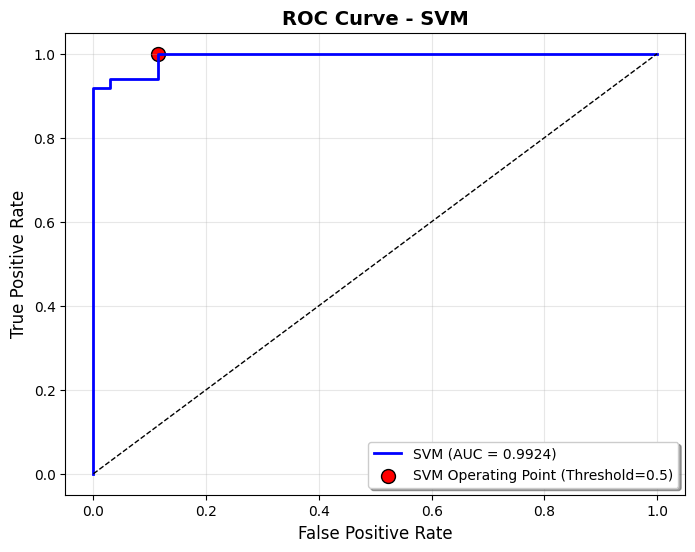

Training Logistic Regression...


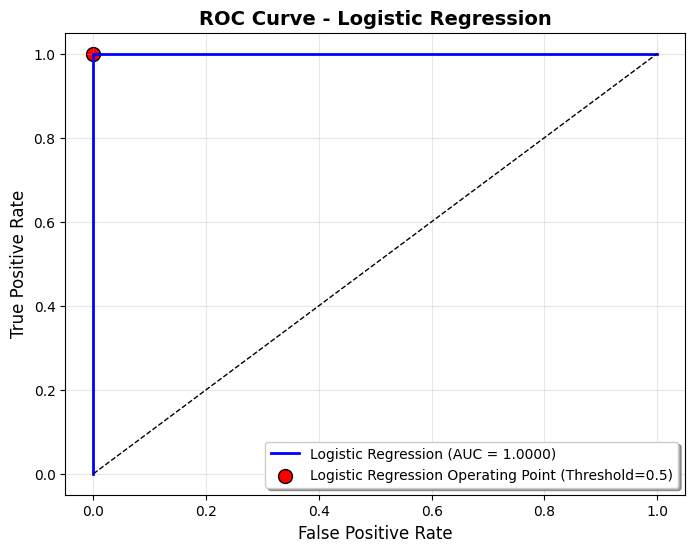

Training Naive Bayes...


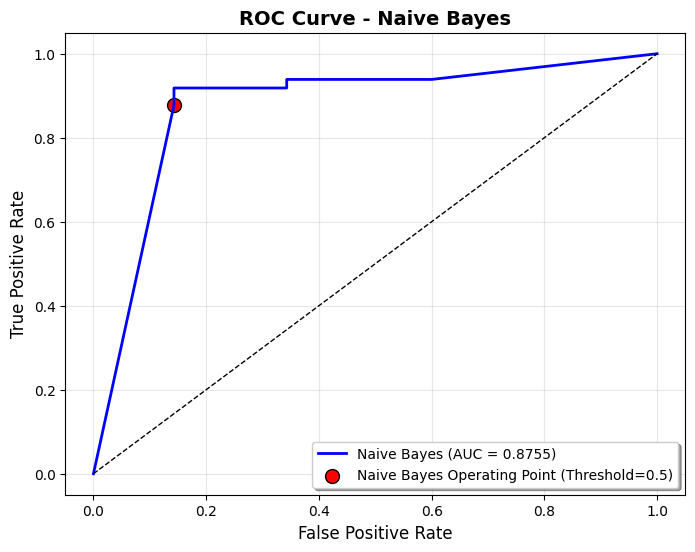

Training Random Forest...


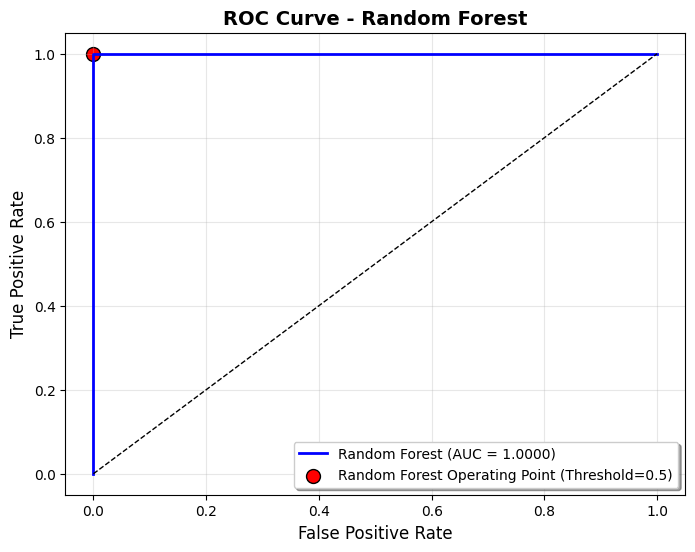

Training Decision Tree...


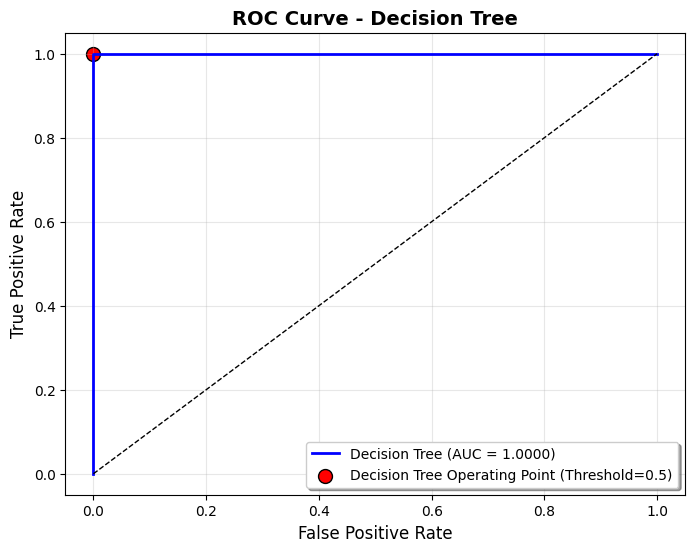

Training AdaBoost...


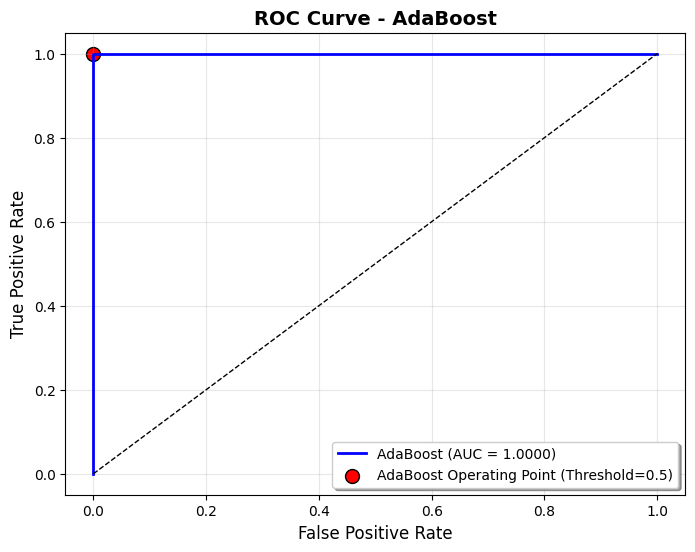

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:38:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


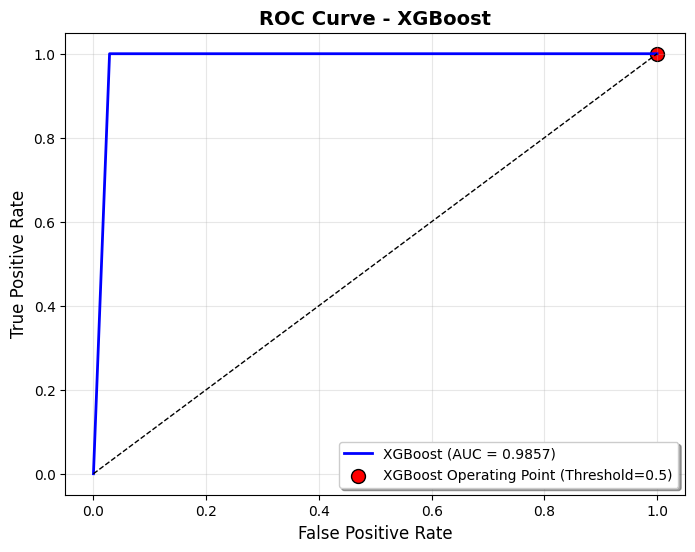

In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

# Step 2: Load the dataset
df = pd.read_csv('/content/kidney_disease_train.csv')  # Update if needed
print("Dataset loaded successfully!")

# Step 3: Handle missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Step 4: Prepare features and target
X = df.drop('classification', axis=1)
y = df['classification']

# Step 5: Correct Manual Encoding
y = y.map({'ckd': 1, 'notckd': 0})

# Step 6: Encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = X.select_dtypes(include=['object']).columns
encoded_features = encoder.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_features)
encoded_df = encoded_df.add_prefix('encoded_')

X = X.drop(categorical_features, axis=1)
X = pd.concat([X, encoded_df], axis=1)

# Step 7: Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Step 9: Define models
models = {
    "SVM": SVC(probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Step 10: Function to plot ROC curve
def plot_roc_curve(model, model_name, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Find operating point (threshold = 0.5)
    op_idx = np.argmin(np.abs(thresholds - 0.5))
    op_fpr, op_tpr = fpr[op_idx], tpr[op_idx]

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=1)

    plt.scatter(op_fpr, op_tpr, color='red', s=100, edgecolor='black', label=f'{model_name} Operating Point (Threshold=0.5)')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {model_name}', fontsize=14, fontweight='bold')

    plt.legend(loc='lower right', fontsize=10, frameon=True, shadow=True)
    plt.grid(alpha=0.3)
    plt.show()

# Step 11: Train and plot ROC for each model
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    plot_roc_curve(model, model_name, X_test, y_test)
